In [59]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv
import operator 
from typing import List, TypedDict, Annotated 
from langchain_core.messages import BaseMessage, HumanMessage, SystemMessage
from langgraph.graph import StateGraph, END 
import json 
import os 
import ast 

In [60]:
load_dotenv()

True

In [61]:
llm = ChatGroq(model = "llama-3.3-70b-versatile")

In [62]:
class LongTermMemory:
    def __init__(self, filepath = "agent_memory2.json"):
        self.filepath = filepath 
        if not os.path.exists(filepath):
            with open(filepath, "w", encoding = 'utf-8') as f:
                json.dump([], f)

    def load_lessons(self):
        """خواندن تمام درس های ذخیره شده"""
        with open(self.filepath, "r", encoding = 'utf-8') as f:
            return json.load(f)
        
    def save_lesson(self, lesson):
        """ذخیره یک درس جدید و مهم"""
        lessons = self.load_lessons()
        if lesson not in lessons:
            lessons.append(lesson)
            with open(self.filepath, "w", encoding = 'utf-8') as f:
                json.dump(lessons, f, ensure_ascii = False, indent = 2)
            print(f"درس جدید در حافظه بلند مدت ذخیره شد: {lesson}")

In [63]:
memory_system = LongTermMemory()

In [64]:
class AgentState(TypedDict):
    task: str 
    response_attempt: str
    feedback: str 
    attempt_count: int 
    solved: bool

In [65]:
def generator_node(state: AgentState):
    task = state["task"]
    feedback = state.get('feedback', "")

    past_lessons = memory_system.load_lessons()

    system_prompt = "تو یک روانشناس خبره هستی. به سوال کاربر پاسخ بده."

    user_content = f"سوال کاربر: {task}\n"

    if past_lessons:
        user_content += "\n قوانین و درس های مهمی که از تجربه های قبل یاد گرفتی (حتما رعایت کن):\n)"
        for lesson in past_lessons:
            user_content += f"- {lesson}\n"

    if feedback:
        user_content += f"\nتلاش قبلی تو در همین تسک با این خطا مواجه شد: {feedback}\nپاسخ اصلاح شده بده"
    
    messages = [
        SystemMessage(content = system_prompt),
        HumanMessage(content = user_content)
    ]

    response = llm.invoke(messages).content

    print(f"پاسخ شماره {state['attempt_count'] + 1}: {response}")

    return {
        "response_attempt": response,
        "attempt_count": state['attempt_count'] + 1
    }

In [ ]:
def validator_node(state: AgentState):
    raw_response = state['response_attempt']
    task = state['task']

    print(f"\nتلاش--- {state['attempt_count']} ---")

    feedback = "" 
    solved = False 

    system_message = """تو یک متخصص خبره در زمینه تجزیه و تحلیل پاسخ های روانشناسی هستی که با توجه به 7 مورد زیر که باید در یک پاسخ مناسب به سوال روانشناسی ارائه شود، پاسخ را بررسی می کنی و به هر یک از این 7 مورد، با توجه به اینکه تا چه حد در ارائه پاسخ رعایت شده اند از 1 تا 100 امتیاز میدهی. در پاسخ خود فقط عنوان موارد و امتیازی که گرفته اند را ارائه کن و از پاسخ اضافه اجتناب کن.
    1. درک دقیق سؤال مشخص‌کردن اینکه سؤال درباره‌ی چیست: (رفتار، هیجان، شناخت، اختلال، رشد، روابط و…) توجه به بافت سؤال (بالینی، آموزشی، سازمانی، فردی، فرهنگی) تشخیص سطح پاسخ موردنیاز (علمی، عمومی، کاربردی)
    2. چارچوب علمی و نظری اشاره به نظریه‌ها یا رویکردهای معتبر: (مثل شناختی–رفتاری، روان‌تحلیلی، انسان‌گرا، زیستی) پرهیز از نظر شخصیِ بدون پشتوانه در صورت لزوم، اشاره به یافته‌های پژوهشی یا اجماع علمی
    3. تحلیل روان‌شناختی بررسی علت‌ها: (زیستی، روانی، اجتماعی) توضیح مکانیزم‌ها (چرا و چگونه این پدیده رخ می‌دهد) توجه به تفاوت‌های فردی
    4. بُعد هیجانی و همدلانه: نشان‌دادن همدلی و درک تجربه‌ی فرد پرهیز از قضاوت، برچسب‌زنی یا ساده‌انگاری استفاده از لحن حمایت‌گرانه (به‌ویژه در مسائل شخصی)
    5. جنبه‌ی کاربردی و راهکارمحور: ارائه‌ی پیشنهادهای عملی و قابل اجرا تفکیک بین «اطلاع‌رسانی» و «درمان» مشخص‌کردن اینکه چه زمانی مراجعه به متخصص لازم است
    6. ملاحظات اخلاقی: حفظ احترام، محرمانگی و سلامت روان فرد پرهیز از تشخیص قطعی بدون ارزیابی تخصصی شفاف‌سازی محدودیت‌های پاسخ
    7. وضوح: وضوح و ساختار بیان ساده، منظم و قابل فهم استفاده از مثال در صورت نیاز جمع‌بندی کوتاه و روشن
"""

    user_content = f"""
    سوال کاربر: {task}

    پاسخ روانشناس: {raw_response}
    """

    messages = [
        SystemMessage(content = system_message),
        HumanMessage(content = user_content)
    ]

    response1 = llm.invoke(messages).content 

    prompt = f"""
متن زیر را بررسی کن آیا موردی کمتر از 30 امتیاز دارد یا خیر. اگر موردی کمتر از 30 امتیاز دارد، نام آن را فقط به صورت قالب زیر بیان کن:
برای مثال اگر در مورد 'بعد هیجانی و همدلانه' و در مورد 'تحلیل روانشناختی بررسی علت ها' امتیاز کمتر از 30 بود، فقط به صورت زیر آن را در پاسخ خود ارائه کند:
'بعد هیجانی و همدلانه', 'تحلیل روانشناختی بررسی علت ها'.

متن: {response1}
"""
    
    response2 = llm.invoke(prompt).content

    prompt2 = f"""
متن زیر را بررسی کن آیا موردی امتیازی کمتر از 30 دارد یا خیر. فقط و فقط اگر حتی یک مورد امتیازی کمتر از 30 داشت، با کلمه 'True' و اگر هیچ یک از موارد امتیاز کمتر از 30 نداشتند، با کلمه 'False' پاسخ بده.

متن: {response1}
"""

    response3 = llm.invoke(prompt2).content

    try:
        if response3 == 'True':
            raise ValueError(f"قانون نقض شد: در پاسخی که ارائه کرده ای، موارد {response2} امتیاز کمتر از 30 دارند. باید به این موارد در پاسخ خود بیشتر اهمیت بدهی تا امتیاز بالاتری در پاسخ دریافت کنی.")
        print("موفقیت! پاسخ صحیح و منطبق با قوانین است")
        solved = True

    except Exception as e:
        feedback = str(e)

    return {
        "solved": solved,
        "feedback": feedback
    }

In [ ]:
def reflector_node(state: AgentState):
    feedback = state['feedback']
    task = state['task']
    response = state['response_attempt']

    reflection_prompt = (
        f"پاسخی که به سوال من داده شده است، این مشکلات را دارد: {feedback}\n"
        "یک قانون کلی کوتاه (یک خط) استخراج کن که در آینده نیز به درد بخورد.\n"
        "مثلا بگو چه مواردی باید برای بهبود پاسخ بهتر بیشتر در نظر گرفته شوند."
    )

    lesson = llm.invoke([HumanMessage(content = reflection_prompt)]).content 

    memory_system.save_lesson(lesson)

    return {}

In [68]:
def router(state: AgentState):
    if state['solved']:
        return END 
    if state['attempt_count'] > 3:
        return END 
    return "reflector"

In [69]:
workflow = StateGraph(AgentState)

workflow.add_node("generator", generator_node)
workflow.add_node("validator", validator_node)
workflow.add_node("reflector", reflector_node)

workflow.set_entry_point("generator")

workflow.add_edge("generator", "validator")
workflow.add_conditional_edges("validator", router,
                               {
                                   "reflector": "reflector",
                                   END: END
                               })
workflow.add_edge("reflector", "generator")

app = workflow.compile()

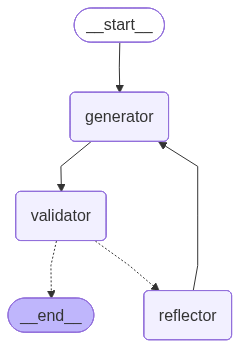

In [13]:
app

In [70]:
def run_agent_test(task: str):
    initial_state = {
        "task": task,
        "response_attempt": "",
        "feedback": "",
        "attempt_count": 0,
        "solved": False
    }

    final_state = app.invoke(initial_state)

    print("\n====== نتیجه نهایی ======")
    print(f"Solved: {final_state.get('solved')}")
    print(f"Attempts: {final_state.get('attempt_count')}")
    print(f"Last feedback: {final_state.get('feedback')}")

    print("\n====== حافظه بلندمدت ======")
    lessons = memory_system.load_lessons()
    for i, lesson in enumerate(lessons, 1):
        print(f"{i}. {lesson}")

    return final_state

In [43]:
run_agent_test("من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟")


تلاش--- 1 ---
درس جدید در حافظه بلند مدت ذخیره شد: برای بهبود پاسخ و دریافت امتیاز بالاتر، باید به مواردی مانند چارچوب علمی و نظری، ارائه مثال‌های بیشتر و استفاده از منابع معتبر بیشتر اهمیت داده شود.

تلاش--- 2 ---
درس جدید در حافظه بلند مدت ذخیره شد: برای بهبود پاسخ و افزایش امتیاز، توجه بیشتر به جنبه‌های هیجانی و همدلانه ضروری است.

تلاش--- 3 ---
موفقیت! پاسخ صحیح و منطبق با قوانین است

====== نتیجه نهایی ======
Solved: True
Attempts: 3
Last feedback: 

====== حافظه بلندمدت ======
1. برای بهبود پاسخ و دریافت امتیاز بالاتر، باید به مواردی مانند چارچوب علمی و نظری، ارائه مثال‌های بیشتر و استفاده از منابع معتبر بیشتر اهمیت داده شود.
2. برای بهبود پاسخ و افزایش امتیاز، توجه بیشتر به جنبه‌های هیجانی و همدلانه ضروری است.


{'task': 'من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟',
 'response_attempt': 'می\u200cتوانم بفهمم که در این شرایط چقدر احساس ناامیدی و سردرگمی می\u200cکنی. مشکل در روابط زناشویی می\u200cتواند بسیار چالش\u200cبرانگیز باشد و احساس بی\u200cثباتی و نگرانی را به همراه داشته باشد. \n\nاول از همه، مهم است که به خودت و همسرت اجازه بدهید تا احساسات و نگرانی\u200cهایتان را به صورت باز و صادقانه بیان کنید. گاهی اوقات، عدم درک یکدیگر می\u200cتواند به دلیل نداشتن یک کانال ارتباطی باز و صادقانه باشد. سعی کنید زمان بگذارید و با هم در مورد نگرانی\u200cها و احساساتتان صحبت کنید. این می\u200cتواند به شما کمک کند تا به درک عمیق\u200cتری از یکدیگر برسید و راه\u200cحل\u200cهای مشترک برای مشکلاتتان پیدا کنید.\n\nاز نظر علمی، نظریه\u200cهای ارتباطی مانند مدل ارتباطی "آیزنبرگ" می\u200cگویند که ارتباط مؤثر در روابط به سه مؤلفه اصلی بستگی دارد: احترام، همدلی و صداقت. سعی کنید این سه مؤلفه را در ارتباطاتتان با همسرتان رعایت کنید.\n\nهمچنین، مراجعه به یک مشاور خانواد

In [44]:
if os.path.exists("agent_memory2.json"):
    os.remove("agent_memory2.json")
    print("حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.")

حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.


In [57]:
run_agent_test("من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟")

پاسخ شماره 1: پاسخ روانشناس: 
درک هر فردی به‌ویژه همسرمان در زندگی مشترک بسیار مهم است. برای درک بهتر همسرتان، می‌توانید اقدامات زیر را انجام دهید:
1. **حفظ ارتباط کلامی**: به‌صورت منظم با همسرتان گفتگو کنید و در مورد احساسات و نیازهایتان به‌صورت باز و صادقانه صحبت نمایید.
2. **گوش دادن فعال**: هنگامی که همسرتان صحبت می‌کند، به‌طور کامل به او گوش دهید و تلاش کنید تا احساسات و دیدگاه‌های او را درک کنید.
3. **همدلی**: خود را به‌جای همسرتان قرار دهید و تلاش کنید تا از دیدگاه او به مسائل نگاه کنید.
4. **پذیرش تفاوت‌ها**: هر فردی دارای تفاوت‌های شخصیتی و فرهنگی است. سعی کنید تا این تفاوت‌ها را قبول کنید و به‌جای تلاش برای تغییر یکدیگر، روی درک و هماهنگی با این تفاوت‌ها تمرکز کنید.
5. **ارزیابی و نقد نکنید**: سعی کنید تا نقد و ارزیابی‌های منفی را به‌حداقل برسانید و به‌جای آن، برpoints قوت و مثبت همسرتان تمرکز کنید.
6. **فعالیت‌های مشترک**: انجام فعالیت‌های مشترک و گذراندن وقت با یکدیگر می‌تواند به افزایش درک و نزدیکی بین شما و همسرتان کمک کند.
7. **مشاوره**: اگر仍 مشکل درک متقابل وجود دارد، م

{'task': 'من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟',
 'response_attempt': 'درک همسر در زندگی زناشویی یک چالش مهم است. برای بهبود درک و ارتباط با همسرتان، می\u200cتوانید از نظریه\u200cهای ارتباطی و روان\u200cشناسی بهره ببرید. یک نظریه مهم در این زمینه، نظریه "اعمال ارتباطی" است که توسط وینچ اشاره به اهمیت درک و تفسیر رفتارهای ارتباطی میان زوجین دارد. \n\nهمچنین، نظریه "دایره ارتباطی" نشان می\u200cدهد که ارتباطات زوجین در یک دایره قرار دارد و هر دو طرف باید به یکدیگر گوش دهند و درک کنند. از طرفی، نظریه "نظریه اتصال" نیز اشاره به اهمیت ایجاد اتصال عاطفی میان زوجین دارد. \n\nبرای درک بهتر همسرتان، می\u200cتوانید از روش\u200cهای زیر استفاده کنید:\n1. **گوش دادن فعال**: تلاش کنید که به سخنان همسرتان با دقت گوش دهید و درک کنید.\n2. **خوش\u200cبینی**: سعی کنید که از جنبه\u200cهای مثبت همسرتان و رابطه\u200cتان نگاه کنید.\n3. **ارتباط باز**: ارتباط باز و صادقانه با همسرتان داشته باشید و احساسات و نیازهایتان را به وضوح بیان کنید.\n4. **احترام متقا

In [58]:
if os.path.exists("agent_memory2.json"):
    os.remove("agent_memory2.json")
    print("حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.")

حافظه پاک شد. حالا می‌توانید دوباره از تسک ۱ شروع کنید.


In [71]:
resp = run_agent_test("من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟")

پاسخ شماره 1: پاسخ روانشناس: 
درک همسر خود در زندگی زناشویی بسیار مهم است. برای حل این مشکل، می‌توانید از روش‌های زیر استفاده کنید:

1. **ارتباط باز و صادقانه**: سعی کنید با همسر خود به صورت باز و صادقانه صحبت کنید. از او بپرسید که چه احتیاجات و انتظاراتی دارد و چه چیزهایی او را ناراحت می‌کند.

2. **فهم انتظارات**: تلاش کنید انتظارات و نیازهای همسر خود را بفهمید. ممکن است برخی از این انتظارات به فرهنگ، تربیت یا تجربیات گذشته او مربوط شود.

3. **حضور در لحظه**: تلاش کنید در زمان صحبت با همسر خود، کاملاً در لحظه حاضر باشید. این به شما کمک می‌کند تا بتوانید به طور EFFECTIVE به او گوش دهید و احساسات او را درک کنید.

4. **توجه به زبان بدن**: علاوه بر کلمات، زبان بدن و رفتارهای غیرکلامی همسر خود را نیز بررسی کنید. این می‌تواند کمک‌کننده باشد تا بتوانید احساسات و نیازهای او را بهتری درک کنید.

5. **کمک گرفتن از مشاور**: اگر احساس می‌کنید که نمی‌توانید به تنهایی به درک همسر خود برسید، می‌توانید از مشاور یا روانشناس ازدواج کمک بگیرید. آنها می‌توانند با ارائه تکنیک‌های ارتباطی و درک بهتر، به شما

In [73]:
resp

{'task': 'من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟',
 'response_attempt': 'درک یکدیگر در زندگی زناشویی، یکی از مهم\u200cترین عوامل برای ایجاد یک رابطه سالم و پایدار است. برای بهبود درک همسرتان و حل vấnدهای زندگی زناشویی، چندین راهکار وجود دارد که می\u200cتوانند به شما کمک کنند:\n\n1. **ارتباط موثر**: ارتباط موثر در زندگی زناشویی بسیار مهم است. این شامل گوش دادن فعالانه، ابراز احساسات و نیازهای خود به وضوح، و避یدن قضاوت و انتقاد است. سعی کنید تا در گفتگوهایتان با همسرتان، به\u200cجای تمرکز بر نقطه\u200cنظرات مختلف، به\u200cدنبال درک دیدگاه یکدیگر باشید.\n\n2. **خروج از زون راحتی**: گاهی اوقات، ما در یک الگوی رفتاری خاص قرار می\u200cگیریم که به\u200cصورت ناخودآگاه تکرار می\u200cشود. تلاش کنید تا از این الگوها خارج شوید و با همسرتان به\u200cصورت باز و صادقانه در مورد نگرانی\u200cها و احساساتتان صحبت کنید.\n\n3. **همراهی و همدلی**: سعی کنید تا خود را جای همسرتان قرار دهید و تلاش کنید تا احساسات و نیازهای او را درک کنید. این به شما کمک می\u20

In [74]:
print(resp["response_attempt"])

درک یکدیگر در زندگی زناشویی، یکی از مهم‌ترین عوامل برای ایجاد یک رابطه سالم و پایدار است. برای بهبود درک همسرتان و حل vấnدهای زندگی زناشویی، چندین راهکار وجود دارد که می‌توانند به شما کمک کنند:

1. **ارتباط موثر**: ارتباط موثر در زندگی زناشویی بسیار مهم است. این شامل گوش دادن فعالانه، ابراز احساسات و نیازهای خود به وضوح، و避یدن قضاوت و انتقاد است. سعی کنید تا در گفتگوهایتان با همسرتان، به‌جای تمرکز بر نقطه‌نظرات مختلف، به‌دنبال درک دیدگاه یکدیگر باشید.

2. **خروج از زون راحتی**: گاهی اوقات، ما در یک الگوی رفتاری خاص قرار می‌گیریم که به‌صورت ناخودآگاه تکرار می‌شود. تلاش کنید تا از این الگوها خارج شوید و با همسرتان به‌صورت باز و صادقانه در مورد نگرانی‌ها و احساساتتان صحبت کنید.

3. **همراهی و همدلی**: سعی کنید تا خود را جای همسرتان قرار دهید و تلاش کنید تا احساسات و نیازهای او را درک کنید. این به شما کمک می‌کند تا با او ارتباط عمیق‌تری برقرار کنید و درک بهتری از یکدیگر پیدا کنید.

4. **دسترسی به منابع و حمایت**: استفاده از منابع و حمایت‌های موجود می‌تواند به شما کمک کند تا درک بهتری از یک

In [75]:
r = llm.invoke("""سه روانشناس هر یک جواب مختلف به سوال زیر داده اند:
سوال: من در زندگی زناشویی به مشکل برخورد کرده ام و نمی توانم خانمم را درک کنم. چه کار باید بکنم؟

جواب روانشناس اول:
درک همسر خود در زندگی زناشویی بسیار مهم است. برای حل این مشکل، می‌توانید از روش‌های زیر استفاده کنید:

1. **ارتباط باز و صادقانه**: سعی کنید با همسر خود به صورت باز و صادقانه صحبت کنید. از او بپرسید که چه احتیاجات و انتظاراتی دارد و چه چیزهایی او را ناراحت می‌کند.

2. **فهم انتظارات**: تلاش کنید انتظارات و نیازهای همسر خود را بفهمید. ممکن است برخی از این انتظارات به فرهنگ، تربیت یا تجربیات گذشته او مربوط شود.

3. **حضور در لحظه**: تلاش کنید در زمان صحبت با همسر خود، کاملاً در لحظه حاضر باشید. این به شما کمک می‌کند تا بتوانید به طور EFFECTIVE به او گوش دهید و احساسات او را درک کنید.

4. **توجه به زبان بدن**: علاوه بر کلمات، زبان بدن و رفتارهای غیرکلامی همسر خود را نیز بررسی کنید. این می‌تواند کمک‌کننده باشد تا بتوانید احساسات و نیازهای او را بهتری درک کنید.

5. **کمک گرفتن از مشاور**: اگر احساس می‌کنید که نمی‌توانید به تنهایی به درک همسر خود برسید، می‌توانید از مشاور یا روانشناس ازدواج کمک بگیرید. آنها می‌توانند با ارائه تکنیک‌های ارتباطی و درک بهتر، به شما کمک کنند تا روابطتان را بهبود ببخشید.

6. **تحمل و صبر**: درک همسر خود به زمان و صبر نیاز دارد. ممکن است که در برخی مواقع، به زمان نیاز باشد تا بتوانید به درک عمیق‌تری از همسر خود برسید.

جواب روانشناس دوم:
براساس نظریه های روانشناسی، درک متقابل در روابط زناشویی از اهمیت زیادی برخوردار است. برای بهبود درک خود از همسرتان و حل مشکلات زندگی زناشویی، می توانید از چند استراتژی زیر استفاده کنید:

1. **ارتباط موثر**: بر اساس نظریه ارتباطی، یکی از مهم ترین عوامل در بهبود روابط زناشویی، ارتباط موثر است. این شامل گوش دادن فعال، ابراز احساسات به روشنی، و避ی از قضاوت و انتقاد است. سعی کنید که در گفتگوهای خود با همسرتان، به دقت به حرف های او گوش دهید و احساسات خود را به روشنی بیان کنید.

2. **همدلی**: از نظریه های روانشناسی اجتماعی، همدلی یکی از کلیدهای مهم درک متقابل است. تلاش کنید که خود را در جایگاه همسرتان قرار دهید و احساسات او را درک کنید. این نه تنها به فهم بهتر مشکلات او کمک می کند، بلکه به ایجاد محیطی صمیمی و حمایتگرانه در روابط شما نیز کمک می کند.

3. **نظریه نظام های خانواده**: بر اساس این نظریه، خانواده به عنوان یک سیستم در نظر گرفته می شود که در آن هر عضو تحت تأثیر رفتار و عملکرد سایر اعضا است. درک این نظام و شناخت نقش خود و همسرتان در آن می تواند به شما در مدیریت تعاملات و حل مشکلات کمک کند.

4. **درمان زوج درمانی**: اگر مشکلات شما به حدی nghiêmج است که خودتان نمی توانید حل کنید، مراجعه به یک روانشناس متخصص در زمینه زوج درمانی می تواند بسیار مفید باشد. این متخصصان می توانند به شما و همسرتان در درک بهتر یکدیگر و پیدا کردن راه حل های موثر برای مشکلاتتان کمک کنند.

5. **نظریه های 첨부 و دلبستگی**: بر اساس نظریه های دلبستگی، سبک دلبستگی هر فرد می تواند影響 زیادی بر روابط او داشته باشد. شناخت سبک دلبستگی خود و همسرتان و تلاش برای ایجاد یک سبک دلبستگی健康 تر می تواند به بهبود روابط شما کمک کند.

با استفاده از این چارچوب های علمی و نظری، می توانید به درک بهتری از همسرتان و روابط خود برسید و مشکلات زندگی زناشویی خود را به طور موثرتری حل کنید.

جواب روانشناس سوم:
درک یکدیگر در زندگی زناشویی، یکی از مهم‌ترین عوامل برای ایجاد یک رابطه سالم و پایدار است. برای بهبود درک همسرتان و حل vấnدهای زندگی زناشویی، چندین راهکار وجود دارد که می‌توانند به شما کمک کنند:

1. **ارتباط موثر**: ارتباط موثر در زندگی زناشویی بسیار مهم است. این شامل گوش دادن فعالانه، ابراز احساسات و نیازهای خود به وضوح، و避یدن قضاوت و انتقاد است. سعی کنید تا در گفتگوهایتان با همسرتان، به‌جای تمرکز بر نقطه‌نظرات مختلف، به‌دنبال درک دیدگاه یکدیگر باشید.

2. **خروج از زون راحتی**: گاهی اوقات، ما در یک الگوی رفتاری خاص قرار می‌گیریم که به‌صورت ناخودآگاه تکرار می‌شود. تلاش کنید تا از این الگوها خارج شوید و با همسرتان به‌صورت باز و صادقانه در مورد نگرانی‌ها و احساساتتان صحبت کنید.

3. **همراهی و همدلی**: سعی کنید تا خود را جای همسرتان قرار دهید و تلاش کنید تا احساسات و نیازهای او را درک کنید. این به شما کمک می‌کند تا با او ارتباط عمیق‌تری برقرار کنید و درک بهتری از یکدیگر پیدا کنید.

4. **دسترسی به منابع و حمایت**: استفاده از منابع و حمایت‌های موجود می‌تواند به شما کمک کند تا درک بهتری از یکدیگر پیدا کنید. این می‌تواند شامل مشاوره زوجی، کتاب‌ها و مقالات در مورد ارتباطات سالم، و حمایت از دوستان و خانواده باشد.

5. **اخلاق و احترام**: در زندگی زناشویی، حفظ اخلاق و احترام متقابل بسیار مهم است. سعی کنید تا در هر شرایطی، به‌جای درگیری و بحث، به‌دنبال راهی برای حل مشکل به‌صورت صلح‌آمیز باشید.

6. **آموزش و خودشناسی**: خودشناسی و آموزش در مورد روابط سالم و ارتباطات موثر می‌تواند به شما کمک کند تا درک بهتری از یکدیگر پیدا کنید. مطالعه کتاب‌ها و 参 Addiction در این زمینه می‌تواند مفید باشد.

7. **ملاحظات اخلاقی**: در تمام مراحل، به ملاحظات اخلاقی توجه کنید. این شامل احترام به یکدیگر، صداقت، و پایبندی به اصول اخلاقی در روابط است. توجه به این اصول می‌تواند به شما کمک کند تا رابطه‌ای سالم و پایدار داشته باشید.

8. **آگاهی از مخاطب**: درک مخاطب (در این caso، همسرتان) بسیار مهم است. سعی کنید تا به‌جای فرض کردن که چه می‌خواهد، از او بپرسید و به‌صورت باز و صادقانه با او صحبت کنید.

با پیروی از این راهکارها و با توجه به ملاحظات اخلاقی و آگاهی از مخاطب، می‌توانید درک بهتری از یکدیگر پیدا کنید و زندگی زناشویی سالم و پایداری داشته باشید

بر طبق 7 جنبه ای که برای تو تشریح شد، هر سه جواب را بررسی کن و برای هر جواب بر اساس رعایت این هفت جنبه، به هر جنبه امتیاز از 0 تا 100 بده.""")

In [76]:
re = r.content

In [78]:
print(re)

بر اساس هفت جنبه‌ای که برای بررسی جواب‌های روانشناسان ارائه شده است، می‌توانیم هر یک از جواب‌ها را ارزیابی کنیم. هفت جنبه عبارتند از:

1. **ارتباط موثر**
2. **همدلی**
3. **نظریه‌های روانشناسی**
4. **راهکارهای عملی**
5. **ملاحظات اخلاقی**
6. **خودشناسی و آموزش**
7. **آگاهی از مخاطب**

اکنون، هر یک از جواب‌های روانشناسان را بر اساس این هفت جنبه ارزیابی می‌کنیم:

**جواب روانشناس اول:**

1. **ارتباط موثر**: 80 (زبان بدن و گوش دادن فعالانه را提 می‌کند)
2. **همدلی**: 60 (تلاش برای درک همسر را提 می‌کند اما به‌صورت عمیق توضیح نمی‌دهد)
3. **نظریه‌های روانشناسی**: 40 (هیچ نظریه خاصی را提 نمی‌کند)
4. **راهکارهای عملی**: 90 (شش راهکار عملی ارائه می‌کند)
5. **ملاحظات اخلاقی**: 50 (به‌صورت کلی به اهمیت درک و ارتباط اشاره می‌کند)
6. **خودشناسی و آموزش**: 30 (مطالعه و خودشناسی را提 نمی‌کند)
7. **آگاهی از مخاطب**: 70 (از پرسیدن از همسر برای درک نیازهای او صحبت می‌کند)

**جواب روانشناس دوم:**

1. **ارتباط موثر**: 90 (گوش دادن فعالانه و ابراز احساسات را提 می‌کند)
2. **همدلی**: 80 (همدلی و قرار گرفتن در جایگاه